In [1]:
%matplotlib inline
import os
import sys

#import tensorflow as tf

import keras
import matplotlib.pyplot as plt

import numpy as np

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, \
                            Activation, add, Add, Dropout, Concatenate, AveragePooling2D, GlobalAveragePooling2D, \
                            Reshape, Lambda, UpSampling2D,Layer
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.utils import to_categorical, plot_model
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import regularizers, metrics
from keras.applications.imagenet_utils import preprocess_input
from keras.losses import binary_crossentropy

from sklearn.model_selection import train_test_split
import pandas as pd

import zipfile
import io
from PIL import Image
from tqdm import tqdm
import math
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import cv2
from imgaug import augmenters as iaa

random_state = 42
THRESHOLD = 0.05

def resblock(x, filters=64, kernel_size=(3, 3), activation='relu'):
    x_ = Conv2D(filters, kernel_size, padding='same')(x)
    x_ = BatchNormalization()(x_)
    x_ = Conv2D(filters, kernel_size, padding='same')(x_)
    x = Add()([x_, x])
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def resblock2(x, filters=64, kernel_size=(3, 3), activation='relu'):
    x = Conv2D(filters, (1,1), padding='same')(x) 
    x_ = BatchNormalization()(x)
    x_ = Conv2D(filters, (1,1), padding='same')(x_)
    x_ = BatchNormalization()(x_)
    x_ = Activation(activation)(x_)
    x_ = Conv2D(filters, kernel_size, padding='same')(x_)
    x_ = BatchNormalization()(x_)
    x_ = Activation(activation)(x_)
    x_ = Conv2D(filters, (1,1), padding='same')(x_)
    x_ = BatchNormalization()(x_)
    x = Add()([x_, x])
    return x

def resnet2(x, filters=64, kernel_size=(3, 3), depth=10):
    for i in range(depth):
        x = resblock2(x, filters=filters)
    return x

def dense_block(x, input_channels, growth_rate, nb_blocks):
    n_channels = input_channels
    orig = x
    for i in range(nb_blocks):
        x = BatchNormalization()(x)
        x = LeakyReLU(0.1)(x) #Activation("relu")(x)
        x = Conv2D(128, (1, 1), kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.1)(x) #Activation("relu")(x)
        # フィルター数 = 成長度合
        x = Conv2D(growth_rate, (3, 3), padding="same", kernel_initializer='he_normal')(x)
        # origと結合
        x = Concatenate()([orig, x])
        n_channels += growth_rate
    return x, n_channels

def transition_layer(x, input_channels, compression_factor=0.5):
    n_channels = int(input_channels * compression_factor)
    x = Conv2D(n_channels, (1, 1))(x)
    x = AveragePooling2D((2, 2))(x)
    return x, n_channels

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        eps =1e-12
        y_pred = K.clip(y_pred, eps, 1.-eps)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def darknet_block(x, input_channels):
    ch_hid = input_channels//2
    _x = x
    x = Conv2D(ch_hid, (1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(input_channels, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Add()([x, _x])
    return x

def weighted_binary_crossentropy(y_true, y_pred):
    eps =1e-12
    y_pred = K.clip(y_pred, eps, 1.-eps)
    zero_weight= 0.2
    one_weight=0.8
    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

Using TensorFlow backend.


In [2]:
#bounding boxの平均値とかを算出
bounding_boxes = pd.read_csv("data/bounding_boxes.csv", engine='python')

#平均サイズを算出　(cnnのinputとして使う)
bounding_boxes['x_size'] = bounding_boxes['x1'] - bounding_boxes['x0']
bounding_boxes['y_size'] = bounding_boxes['y1'] - bounding_boxes['y0']
average_xs = bounding_boxes['x_size'].mean()
average_ys = bounding_boxes['y_size'].mean()
print('x: ', average_xs, '  y: ', average_ys)

#x:y = 3:1 =  くらいなので、300x100とする
#なので、inputは100x300

x:  897.1672518831967   y:  291.3247201464542


In [3]:
#bounding boxをdataに対応付ける
data = pd.read_csv("data/train.csv", engine='python') 
data = pd.merge(data, bounding_boxes, how="inner" ,on="Image")

In [4]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m,256, 256, 3))
    count = 0   
    for fig, x0, x1, y0, y1 in zip(data['Image'], data['x0'], data['x1'], data['y0'], data['y1']):
        #load images into images of size 300x100x3
        #print(fig, x0, x1)
        im_pth = "data/"+dataset+"/"+fig
        im = Image.open(im_pth)
        im = im.convert('RGB')
        #トリミングする
        im = im.crop((x0, y0, x1, y1 ))  #left, upper, right, lower
        im = im.resize((256, 256), Image.ANTIALIAS)
        x = np.array(im)
        X_train[count] = x/255
        if count%5000== 0:
            print("Processing image: ", count+1, ", ", fig)
            #break
        count += 1
    return X_train.astype(np.float32)

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

def prepareDatasetForMoVAE(images, labels, label):
    ret_x = []
    for i in len(labels):
        if labels[i] == label:
            ret_x.append(images[i])
    return np.array(ret_x)

Done


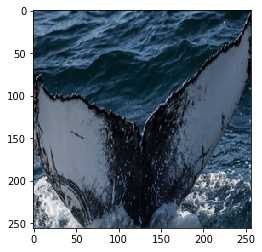

In [5]:
y_train, label_encoder = prepare_labels(data['Id'])

x_train = np.load('data/x_train_256x256_20190201.npy')
#x_train = prepareImages(data, len(data), 'train')
#np.save('data/x_train_256x256_20190201.npy', x_train)

print("Done")
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
plt.imshow(x_train[0])

In [6]:
def sampling(args, latent_dim=64):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim,), mean=0.,
                              stddev=1.0)
    return z_mean + K.exp(z_log_var) * epsilon

def encoder_model(latent_dim=64, n=16, k=32):
    xin = Input(shape=(256,256,3,))
    x = Conv2D(n, (1,1), kernel_initializer='he_normal')(xin)
    x, n = dense_block(x, n, k, 2)
    x, n = transition_layer(x, n)

    x, n = dense_block(x, n, k, 4)
    x, n = transition_layer(x, n)

    x, n = dense_block(x, n, k, 8)
    x, n = transition_layer(x, n)

    x, n = dense_block(x, n, k, 4)
    x, n = transition_layer(x, n)

    h = GlobalAveragePooling2D()(x)
    z_mean = Dense(latent_dim)(h) # 潜在変数の平均 μ
    z_log_var = Dense(latent_dim)(h) #潜在変数の分散 σのlog
    z = Lambda(sampling, output_shape=(64,))([z_mean, z_log_var])
    encoder_model = Model(xin, [z_mean, z_log_var,z])
    return encoder_model


def decoder_model(latent_dim=64, nch=64):
    # Lambdaを使って式をwrap
    zin = Input(shape=(latent_dim,))  
    h = Dense(nch*32*32, kernel_initializer='glorot_normal')(zin)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Reshape( [32, 32, nch] )(h) # 32*32*64 -> 32x32x64
    h = UpSampling2D(size=(2, 2))(h) # 32x32x64 -> 64x64x64
    h = Conv2D(int(nch), (3, 3), padding='same', kernel_initializer='glorot_uniform')(h) # 64x64x64 -> 64x64x64
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = UpSampling2D(size=(2, 2))(h) # 64x64x64 -> 128x128x64
    h = Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer='glorot_uniform')(h) # 128x128x64 -> 128x128x32
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = UpSampling2D(size=(2, 2))(h) # 128x128x64 -> 256x256x64
    h = Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer='glorot_uniform')(h) # 256x256x32 -> 256x256x16
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Conv2D(int(nch/8), (3, 3), padding='same', kernel_initializer='glorot_uniform')(h) # 256x256x16 -> 256x256x8
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Conv2D(3, (1, 1), padding='same', kernel_initializer='glorot_uniform')(h) # 256x256x8 -> 256x256x3
    model_output = Activation('sigmoid')(h)
    decoder_model = Model(zin, model_output)
    return decoder_model



In [7]:
encoder = encoder_model()
encoder.summary()
#plot_model(encoder, to_file='models/vae_cnn_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 64          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
decoder = decoder_model()
decoder.summary()
#plot_model(decoder, to_file='models/vae_cnn_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 65536)             4259840   
_________________________________________________________________
batch_normalization_37 (Batc (None, 65536)             262144    
_________________________________________________________________
activation_1 (Activation)    (None, 65536)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 64, 64, 64)        36928     
__________

In [9]:
image_in = Input(shape=(256,256,3))

[z_mean, z_log_var,z] = encoder(image_in)

decoded_image = decoder(z)

vae = Model(image_in, decoded_image)

reconstruction_loss = binary_crossentropy(K.flatten(image_in),
                                                  K.flatten(decoded_image))
reconstruction_loss *= 256 * 256 * 3
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
#plot_model(vae, to_file='models/vae_cnn.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
model_1 (Model)              [(None, 64), (None, 64),  1016085   
_________________________________________________________________
model_2 (Model)              (None, 256, 256, 3)       4583667   
Total params: 5,599,752
Trainable params: 5,459,848
Non-trainable params: 139,904
_________________________________________________________________


image_in = Input(shape=(256,256,3))
[z_mean, z_log_var] = encoder(image_in)

decoded_image = decoder(z)

class CustomVariationalLayer(Layer): # Layer classの継承
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded):
        original_dim = 256*256*3
        xent_loss = original_dim * metrics.binary_crossentropy(K.flatten(x), K.flatten(x_decoded)) # 復元誤差: Reconstruction Error
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # 正則化項: KL Divergence
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs) # Layer class のadd_lossを利用
        return x # 実質的には出力は利用しない

y = CustomVariationalLayer()([image_in, decoded_image])
vae = Model(image_in, y) # xをinputにyを出力, 出力は実質関係ない
vae.compile(optimizer='rmsprop', loss=None) # CustomVariationalLayerで追加したLossを利用するのでここでのlossはNoneとする

vae.summary()

In [10]:
def generateData(xs, batch_size=128):
    #data augmentation
    def augment(image):
        augment_img = iaa.Sequential([
                iaa.Affine(rotate=(-45, 45),
                        #translate_px={"x": (-40, 40), "y": (-40, 40)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        shear=(-5, 5)),
                iaa.Fliplr(0.5)
            ], random_order=True)
        image_aug = augment_img.augment_image(image)
        return image_aug

    n_batches = math.ceil(len(xs) / batch_size)
    while True:   
        for i in range(n_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            yield_image = []
            for x in xs[start:end]:
                yield_image.append(augment(x))
            yield np.array(yield_image), None
            


In [12]:
direc1_interrupt = 'models/20190201_interrupt.h5'
direc1 = 'models/20190201_checkpoint.h5'
csv_logger = CSVLogger("models/20190201history.csv")


cb_es = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
check_point = ModelCheckpoint(direc1, monitor='loss', 
                              verbose=1, save_best_only=True, mode='auto', period=1)

batch_size = 16

train_gen = generateData(x_train, batch_size=batch_size)
stepsPepoch = math.ceil(len(x_train) / batch_size)



In [ ]:
try:
    keras_history = vae.fit_generator(train_gen,
                        steps_per_epoch=stepsPepoch, 
                        epochs=1000, 
                        callbacks=[cb_es, check_point, csv_logger], 
                        verbose=1)

except KeyboardInterrupt:
    print("keyboard interrupted")
    vae.save(direc1_interrupt)
    encoder.save('models/encoder.h5')
    decoder.save('models/decoder.h5')

Epoch 1/1000
